In [ ]:
import cv2 as cv
import numpy as np

def nothing(x):
    pass

image = cv.imread('IMG.jpg')
image = cv.resize(image, None, fx = 0.35, fy = 0.35, interpolation = cv2.INTER_LINEAR)

cv.namedWindow('image', cv.WINDOW_AUTOSIZE)

cv.createTrackbar('HMin', 'image', 0, 179, nothing)
cv.createTrackbar('SMin', 'image', 0, 255, nothing)
cv.createTrackbar('VMin', 'image', 0, 255, nothing)
cv.createTrackbar('HMax', 'image', 0, 179, nothing)
cv.createTrackbar('SMax', 'image', 0, 255, nothing)
cv.createTrackbar('VMax', 'image', 0, 255, nothing)

cv.setTrackbarPos('HMax', 'image', 179)
cv.setTrackbarPos('SMax', 'image', 255)
cv.setTrackbarPos('VMax', 'image', 255)

hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

while(1):
    hMin = cv.getTrackbarPos('HMin', 'image')
    sMin = cv.getTrackbarPos('SMin', 'image')
    vMin = cv.getTrackbarPos('VMin', 'image')
    hMax = cv.getTrackbarPos('HMax', 'image')
    sMax = cv.getTrackbarPos('SMax', 'image')
    vMax = cv.getTrackbarPos('VMax', 'image')

    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv, lower, upper)
    result = cv.bitwise_and(image, image, mask=mask)

    if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    cv.imshow('image', result)
    if cv.waitKey(10) & 0xFF == ord('q'):
        break

cv.destroyAllWindows()

In [1]:
import os
import typing
import cv2 as cv
from cv2.typing import MatLike
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
def read_image(path : typing.Union[str, os.PathLike] , mode : str = 'rgb') -> typing.Union[MatLike, None]:
    img = cv.imread(path)
    if mode == 'gray':
        return cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    elif mode == 'rgb':
        return cv.cvtColor(img, cv.COLOR_BGR2RGB)
    elif mode == 'hsv':
        return cv.cvtColor(img, cv.COLOR_BGR2HSV)
    else:
        return None

In [3]:
def show_img(img : MatLike = None, title : str = 'Image', mode : str = 'gray') -> None:
    plt.figure()
    if mode == 'rgb':
        plt.imshow(img)
    elif mode == 'gray':
        plt.gray()
        plt.imshow(img)
    elif mode == 'hsv':
        img = img[:, :, 0]
        plt.hsv()
        plt.imshow(img)
    else:
        return
    plt.title(title)
    plt.show()

In [4]:
def get_RGB_msak(rgb_img : MatLike = None, bw_mask : MatLike = None) -> MatLike:
    rgb_mask = cv.bitwise_and(rgb_img, rgb_img, mask = bw_mask)
    return rgb_mask

In [5]:
def get_mask(hsv_img : MatLike = None, lower_bound : MatLike = None, upper_bound : MatLike = None) -> MatLike:
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)
    BW_mask = cv.inRange(hsv_img, lower_bound, upper_bound)
    return BW_mask

In [6]:
def filter_mask(img: MatLike = None, kernel_size : int = 3) -> MatLike:
    filtered_mask = cv.medianBlur(img, kernel_size)
    return filtered_mask

In [7]:
def erode(img : MatLike = None, kernel_size : tuple = (3, 3)) -> MatLike:
    kernel = np.ones(kernel_size, np.uint8)
    mask = cv.erode(img, kernel)
    return mask

In [8]:
def dilate(img : MatLike = None, kernel_size : tuple = (3, 3)) -> MatLike:
    kernel = np.ones(kernel_size, np.uint8)
    mask = cv.dilate(img, kernel)
    return mask

In [9]:
def morph_open(img : MatLike = None, erode_kernel_size : tuple = (3, 3), dilate_kernel_size : tuple = (3, 3)) -> MatLike:
    eroded = erode(img, erode_kernel_size)
    opened = dilate(eroded, dilate_kernel_size)
    return opened

In [10]:
def morph_close(img : MatLike = None, dilate_kernel_size : tuple = (3, 3), erode_kernel_size : tuple = (3, 3)) -> MatLike:
    dilated = dilate(img, dilate_kernel_size)
    closed = erode(dilated, erode_kernel_size)
    return closed

In [11]:
def fill_holes(img : MatLike = None) -> MatLike:
    img_floodfill = img.copy()
    img_h, img_w = img.shape[:2]
    mask = np.zeros((img_h + 2, img_w + 2), np.uint8)
    cv.floodFill(img_floodfill, mask, (0, 0), 255)
    img_floodfill = cv.bitwise_not(img_floodfill)
    filled_img = cv.bitwise_or(img, img_floodfill)
    return filled_img

In [12]:
def combine_mask(masks : list[MatLike] = None) -> MatLike:
    mask_h, mask_w = masks[0].shape[:2]
    combined_mask = np.zeros((mask_h, mask_w), np.uint8)
    for mask in masks:
        combined_mask = cv.bitwise_or(combined_mask, mask)
    return combined_mask

In [13]:
def get_region_color(hsv_img : MatLike = None, region_coord : MatLike = None) -> MatLike:
    region_coord = region_coord.transpose()
    hsv_values = hsv_img[tuple(zip(region_coord))]
    mean_value = np.mean(hsv_values, axis = 1)
    hsv_color = np.uint8([mean_value])
    rgb_color = cv.cvtColor(hsv_color, cv.COLOR_HSV2RGB)
    R, G, B = rgb_color[0][0]
    H, S, V = hsv_color[0][0]
    return [(int(R), int(G), int(B)), (int(H), int(S), int(V))]

In [14]:
def get_color_name(hsv_color : MatLike = None) -> str:
    H, S, V = hsv_color
    color_dict = {
        'RED'       : {'H' : (0,   20),
                       'S' : (160, 255),
                       'V' : (200, 255)},
        'ORANGE'    : {'H' : (21,  24),
                       'S' : (200, 255),
                       'V' : (200, 255)},
        'YELLOW'    : {'H' : (25,  40),
                       'S' : (200, 255),
                       'V' : (200, 255)},
        'GREEN'     : {'H' : (41,  85),
                       'S' : (80,  140),
                       'V' : (150, 200)},
        'BLUE'      : {'H' : (101, 115),
                       'S' : (150, 180),
                       'V' : (160, 180)},
        'PURPLE'    : {'H' : (116, 130),
                       'S' : (65,  95),
                       'V' : (100, 140)},
        'PINK'      : {'H' : (151, 180),
                       'S' : (65,  85),
                       'V' : (210, 255)},
        'BLACK'     : {'H' : (5,   20),
                       'S' : (50,  70),
                       'V' : (60,  90)},
        'GRAY'      : {'H' : (50,  80),
                       'S' : (0,   25),
                       'V' : (170, 200)},
        'BROWN'     : {'H' : (0,   20),
                       'S' : (40,  60),
                       'V' : (170, 190)},
        'WHITE'     : {'H' : (10,  25),
                       'S' : (0,   10),
                       'V' : (250, 255)}
    }
    
    color_keys = color_dict.keys()
    for color_key in color_keys:
        min_h, max_h = color_dict[color_key]['H']
        min_s, max_s = color_dict[color_key]['S']
        min_v, max_v = color_dict[color_key]['V']
        if (min_h <= H <= max_h) and (min_s <= S <= max_s) and (min_v <= V <= max_v):
            return color_key
    return 'UNDEF'

In [15]:
def get_bbox_coords(bbox : MatLike = None, offset : int = 0) -> MatLike:
    x1 = bbox[0] - offset
    y1 = bbox[1] - offset
    x2 = bbox[2] + bbox[0] + offset
    y2 = bbox[3] + bbox[1] + offset
    return (x1, y1, x2, y2)

In [16]:
def draw_label(rgb_img : MatLike = None, x : int = 0, y : int = 0, text : str = None, rgb_color : MatLike = None) -> None:
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 1.2
    font_thickness = 3
    text_offset = 14
    if text != 'WHITE':
        font_color = (255, 255, 255)
    else:
        font_color = (0, 0 , 0)
    (text_w, text_h), _ = cv.getTextSize(text, font, font_scale, font_thickness)
    cv.rectangle(rgb_img, (x, (y - text_h - text_offset)), (x + text_w, y), rgb_color, -1)
    cv.putText(rgb_img, text, (x, y - text_offset // 2), font, font_scale, font_color, font_thickness)

In [17]:
def draw_bboxes(rgb_img : MatLike = None, bbox : MatLike = None, color : MatLike = None, color_name : str = None, shape_name : str = None) -> None:
    x1, y1, x2, y2 = get_bbox_coords(bbox, 10)
    line_thickness = 10
    if shape_name == 'RECTANGLE':
        cv.rectangle(rgb_img, (x1, y1), (x2, y2), color = color, thickness = line_thickness)
    else:
        c_R = abs((x2 - x1) // 2)
        c_X = x1 + c_R
        c_Y = y1 + c_R  
        cv.circle(rgb_img, (c_X, c_Y), c_R + line_thickness // 2, color = color, thickness = line_thickness)
    draw_label(rgb_img, (x1 - line_thickness // 2), (y1 - line_thickness // 2), color_name, color)

In [18]:
def get_hu_moments(region_mask : MatLike = None) -> MatLike:
    central_moment = cv.moments(region_mask)
    hu_moments = cv.HuMoments(central_moment)
    hu_moments = (-1.0) * np.copysign(1.0, hu_moments) * np.log10(np.absolute(hu_moments))
    return hu_moments

In [19]:
def get_circularity(area : float = 0.0, perimeter : float = 0.0) -> float:
    return (4 * np.pi * area) / np.square(perimeter)

In [20]:
def get_radius_ratio(c_X : int = 0, c_Y : int = 0, contours : MatLike = None) -> float:
    radius_list = []
    for contour in contours:
        cnt_X, cnt_Y = contour[0]
        radius = math.hypot((c_X - cnt_X), (c_Y - cnt_Y))
        radius_list.append(radius)
    max_radius = round(np.max(radius_list), 2)
    min_radius = round(np.min(radius_list), 2)
    return (min_radius / max_radius)

In [21]:
def anylyze_shape(region_mask : MatLike = None) -> str:
    contours, _ = cv.findContours(region_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    central_moments = cv.moments(region_mask)
    cnt_area = cv.contourArea(contours[0])
    perimeter = cv.arcLength(contours[0], True)
    circularity = get_circularity(cnt_area, perimeter)
    hu_moments = get_hu_moments(region_mask)
    c_X = int(central_moments['m10'] / central_moments['m00'])
    c_Y = int(central_moments['m01'] / central_moments['m00'])
    radius_ratio = get_radius_ratio(c_X, c_Y, contours[0])
    if radius_ratio < 0.80 or circularity < 0.85:
        return 'RECTANGLE'
    else:
        return 'CIRCLE'

In [22]:
def classify_objects(rgb_img : MatLike = None, hsv_img : MatLike = None, bw_mask : MatLike = None) -> None:
    img = rgb_img.copy()
    components_stats = cv.connectedComponentsWithStats(bw_mask, 4)
    labels_num : int = components_stats[0]
    labeled_mask : MatLike = components_stats[1]
    bboxes : MatLike = components_stats[2]
    
    for id in range(1, labels_num):
        bbox = bboxes[id]
        x1, y1, x2, y2 = get_bbox_coords(bbox, 10)
        region_mask = bw_mask[y1 : y2, x1 : x2]
        region_mask_rgb = rgb_img[y1 : y2, x1 : x2, :]
        component_coords = np.argwhere(labeled_mask == id)
        rgb_color, hsv_color = get_region_color(hsv_img, component_coords)
        color_name = get_color_name(hsv_color)
        shape_name = anylyze_shape(region_mask)
        show_img(region_mask_rgb, 'OBJECT {}: {} {}'.format(id, color_name, shape_name))
        draw_bboxes(img, bbox, rgb_color, color_name, shape_name)
    return img

In [23]:
def save_IMG(img : MatLike = None, file_name : str = 'IMG.jpg') -> None:
    dirs = os.listdir('./')
    if file_name in dirs:
        print('[ERROR]: File already exist!')
    else:
        cv.imwrite(file_name, cv.cvtColor(img, cv.COLOR_RGB2BGR))
        print('[INFO]:  Image saved successfully.')

# READ IMAGE

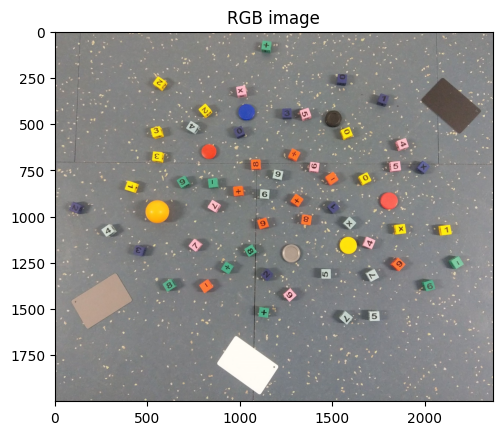

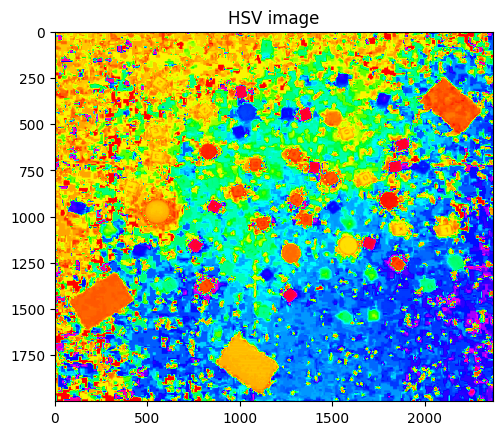

In [24]:
RGB = read_image('IMG.jpg')
HSV = read_image('IMG.jpg', 'hsv')

show_img(RGB, 'RGB image', 'rgb')
show_img(HSV, 'HSV image', 'hsv')

# MASK 1 PREPROCESSING

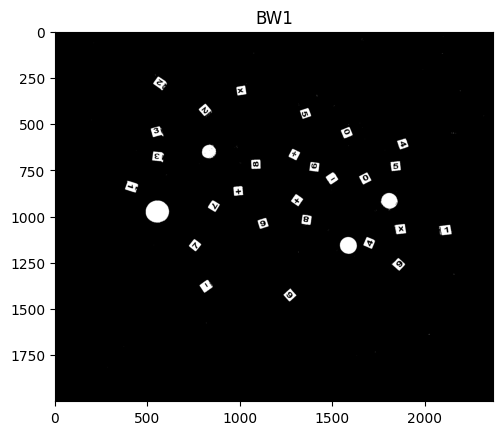

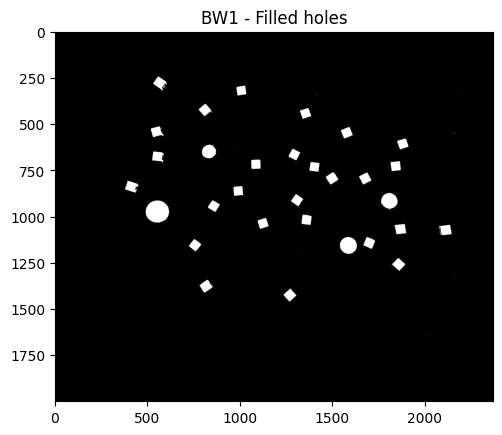

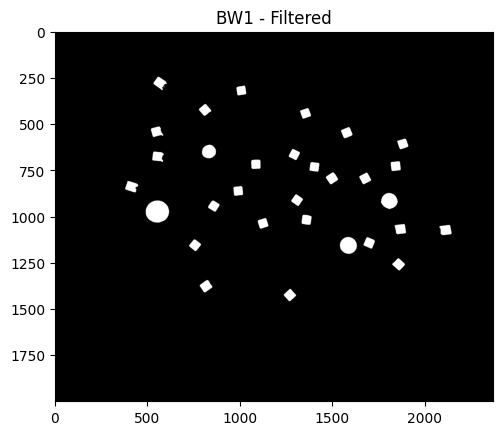

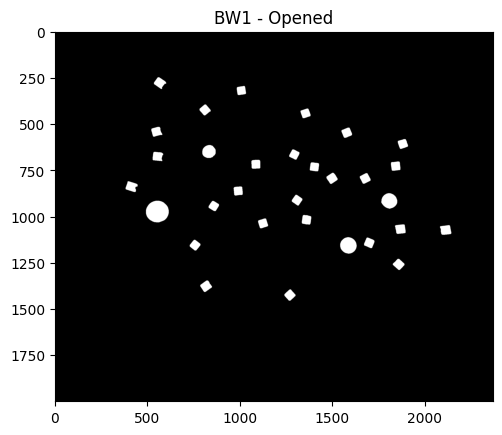

In [25]:
BW1 = get_mask(HSV, [0, 43, 235], [179, 255, 255])
show_img(BW1, 'BW1')

BW1 = fill_holes(BW1)
show_img(BW1, 'BW1 - Filled holes')

BW1 = filter_mask(BW1, 9)
show_img(BW1, 'BW1 - Filtered')

BW1 = morph_open(BW1, (9, 9), (7, 7))
show_img(BW1, 'BW1 - Opened')

# MASK 2 PREPROCESSING

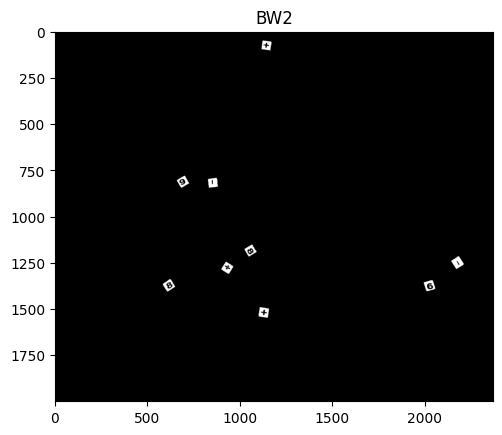

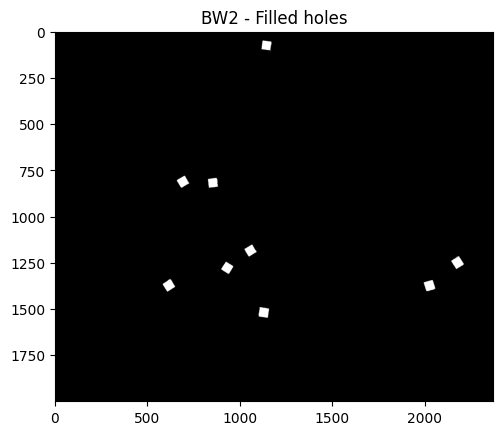

In [26]:
BW2 = get_mask(HSV, [67, 40, 156], [82, 172, 221])
show_img(BW2, 'BW2')

BW2 = fill_holes(BW2)
show_img(BW2, 'BW2 - Filled holes')

# MASK 3 PREPROCESSING

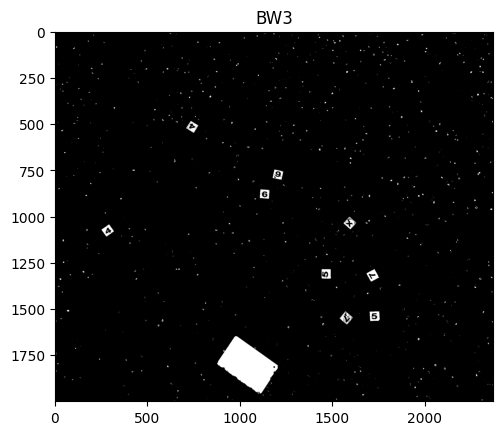

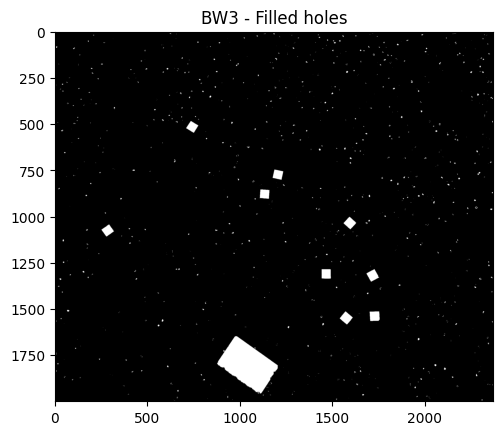

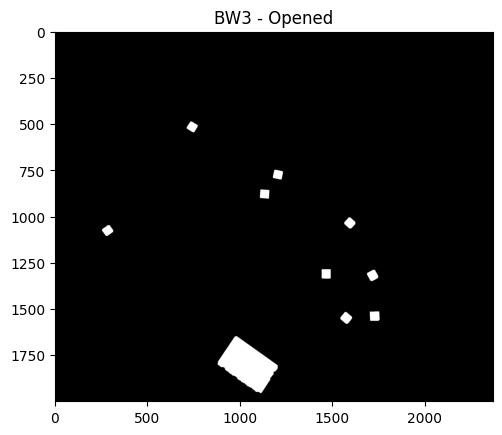

In [27]:
BW3 = get_mask(HSV, [13, 4, 205], [102, 17, 255])
show_img(BW3, 'BW3')

BW3 = fill_holes(BW3)
show_img(BW3, 'BW3 - Filled holes')

BW3 = morph_open(BW3, (9, 9), (9, 9))
show_img(BW3, 'BW3 - Opened')

# MASK 4 PREPROCESSING

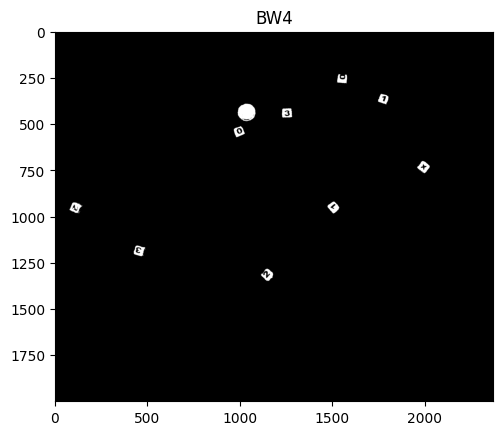

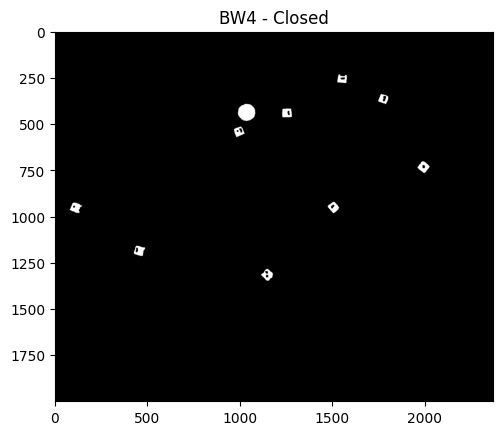

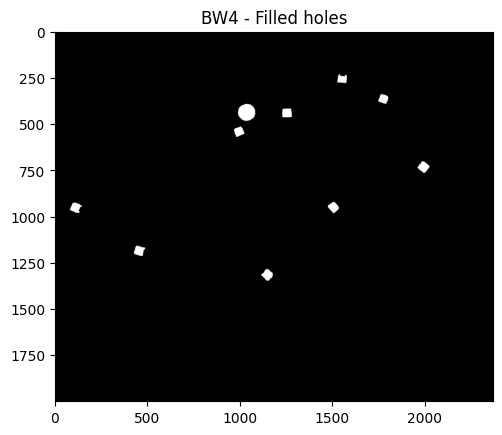

In [28]:
BW4 = get_mask(HSV, [89, 49, 100], [140, 200, 200])
show_img(BW4, 'BW4')

BW4 = morph_close(BW4, (7, 7), (9, 9))
show_img(BW4, 'BW4 - Closed')

BW4 = fill_holes(BW4)
show_img(BW4, 'BW4 - Filled holes')

# MASK 5 PREPROCESSING

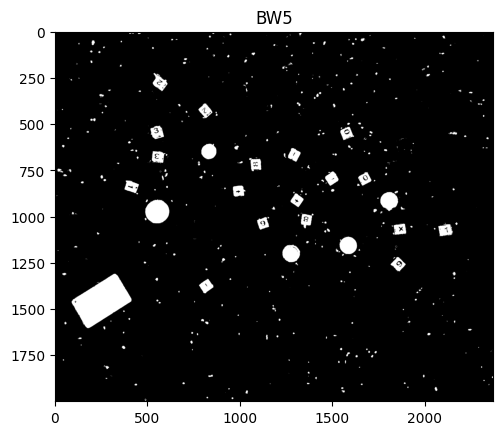

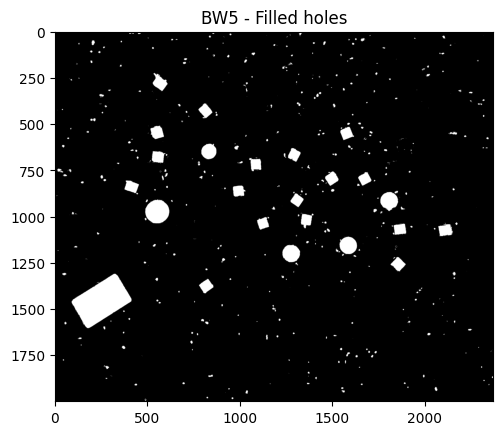

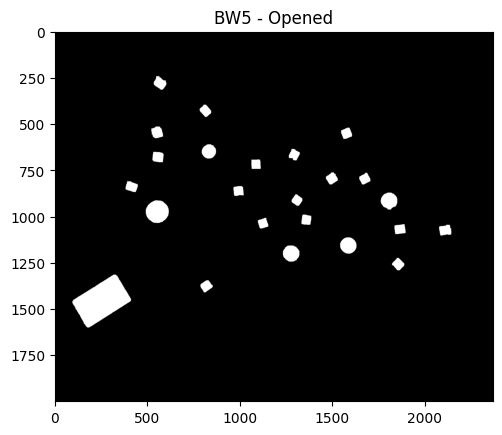

In [29]:
BW5 = get_mask(HSV, [0, 30, 150], [30, 255, 255])
show_img(BW5, 'BW5')

BW5 = fill_holes(BW5)
show_img(BW5, 'BW5 - Filled holes')

BW5 = morph_open(BW5, (15, 15), (11, 11))
show_img(BW5, 'BW5 - Opened')

# MASK 6 PREPROCESSING

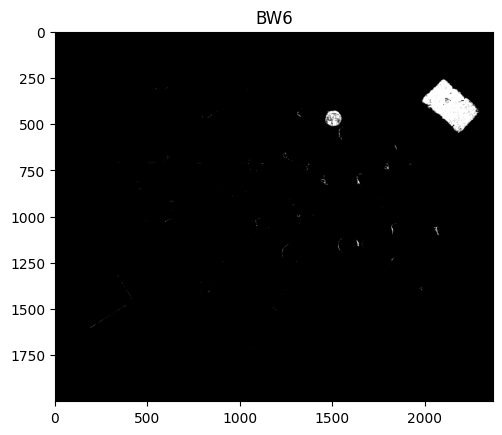

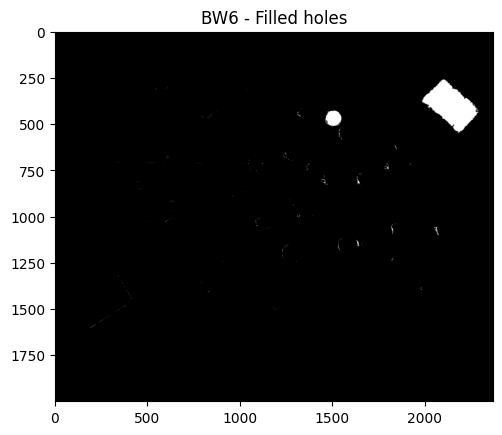

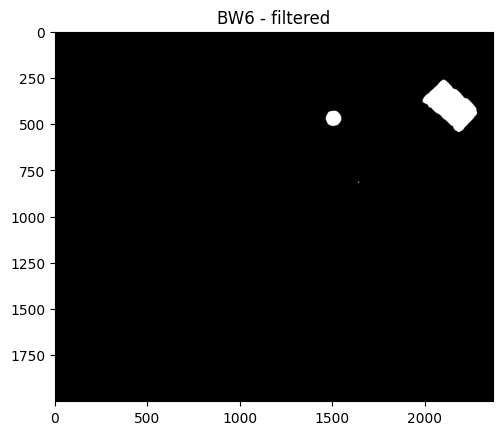

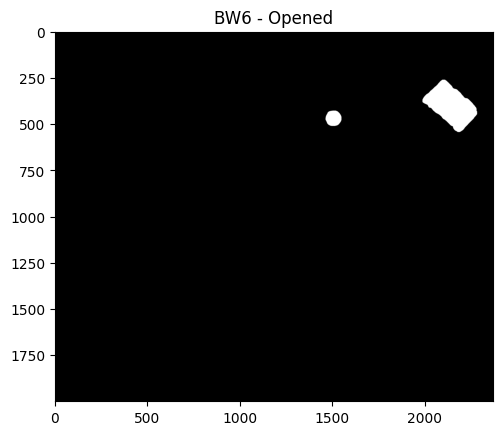

In [30]:
BW6 = get_mask(HSV, [3, 40, 45], [26, 70, 100])
show_img(BW6, 'BW6')

BW6 = fill_holes(BW6)
show_img(BW6, 'BW6 - Filled holes')

BW6 = filter_mask(BW6, 15)
show_img(BW6, 'BW6 - filtered')

BW6 = morph_open(BW6, (9, 9), (11, 11))
show_img(BW6, 'BW6 - Opened')

# MASK COMBINATION

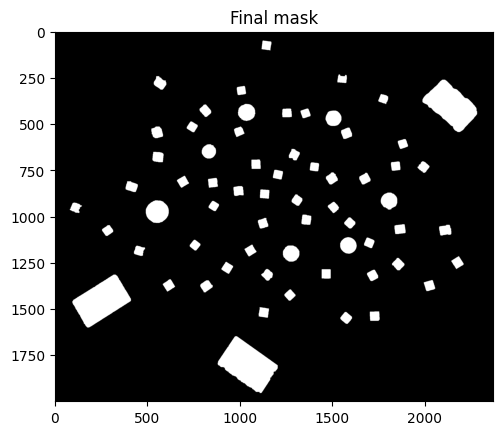

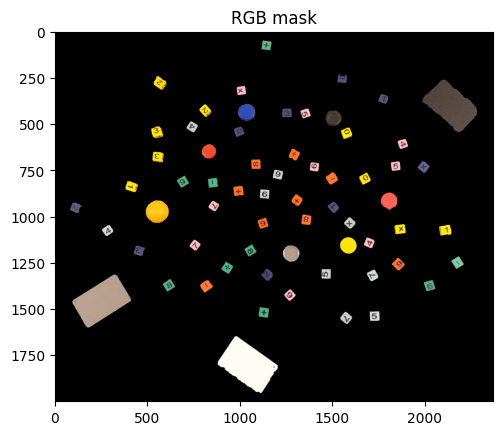

In [31]:
masks_list = [BW1, BW2, BW3, BW4, BW5, BW6]

BW_MASK = combine_mask(masks_list)
BW_MASK = filter_mask(BW_MASK, 3)
show_img(BW_MASK, 'Final mask')

RGB_MASK = get_RGB_msak(RGB, BW_MASK)
show_img(RGB_MASK, 'RGB mask', 'rgb')

# OBJECTS CLASSIFICATION

The image with the labels applied is at the very bottom of the script

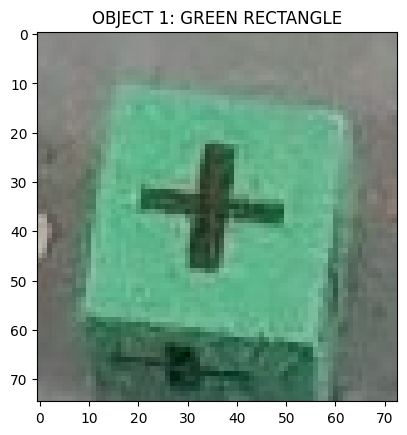

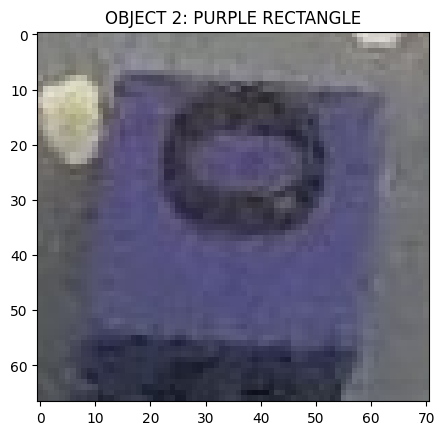

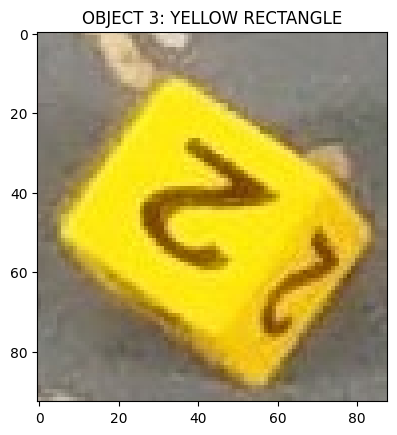

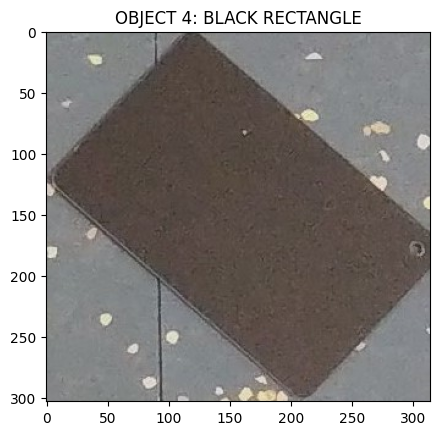

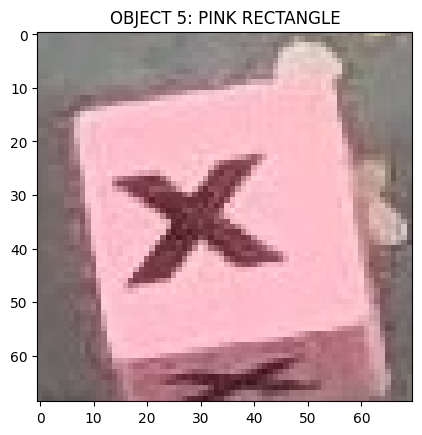

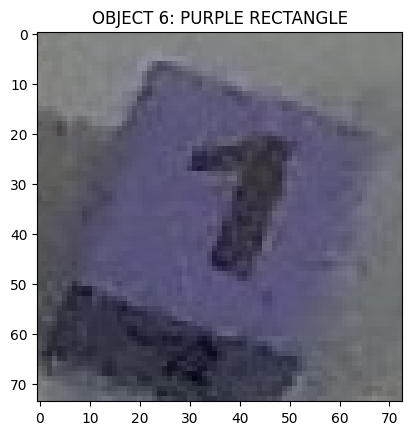

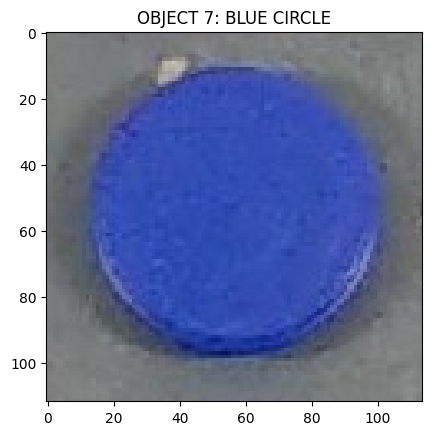

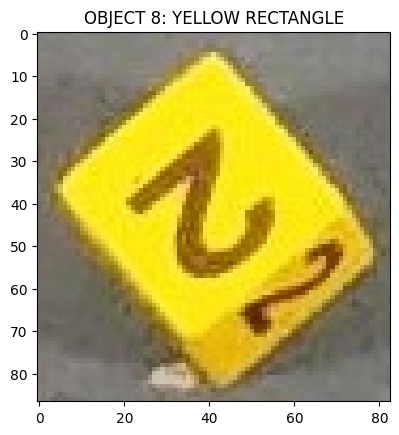

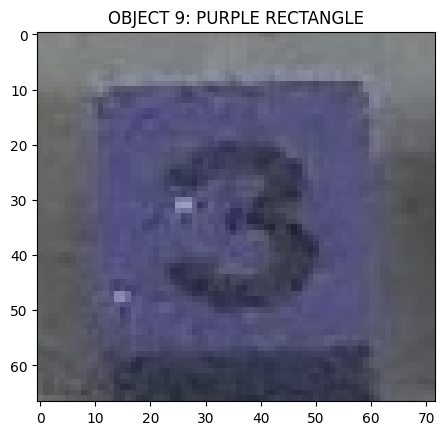

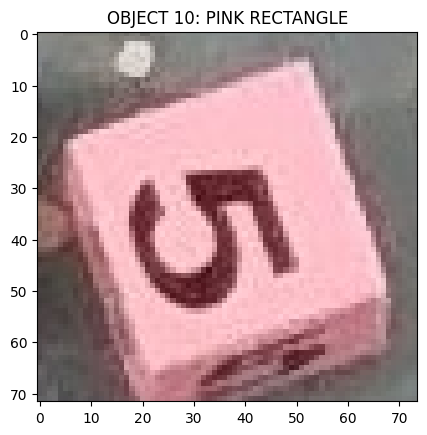

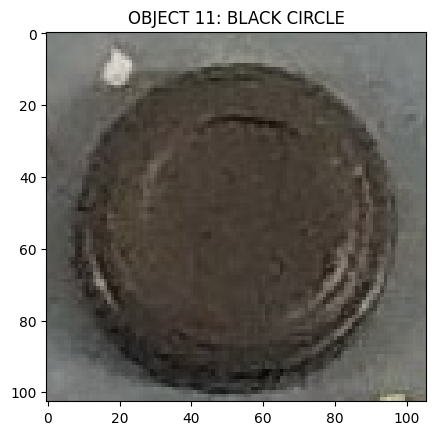

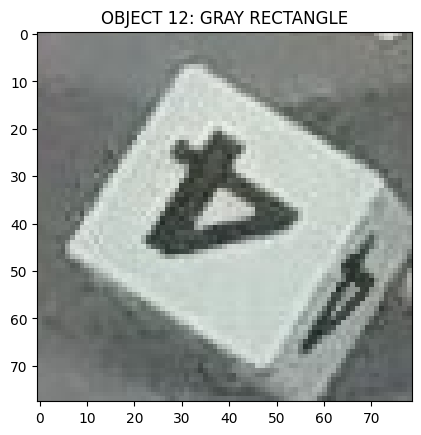

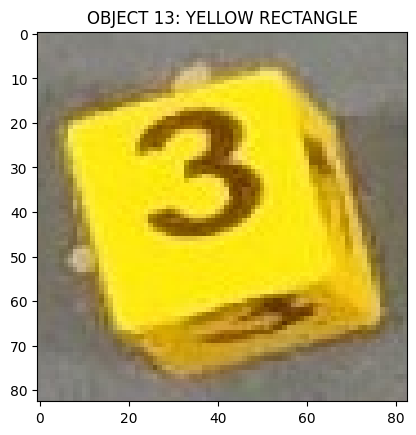

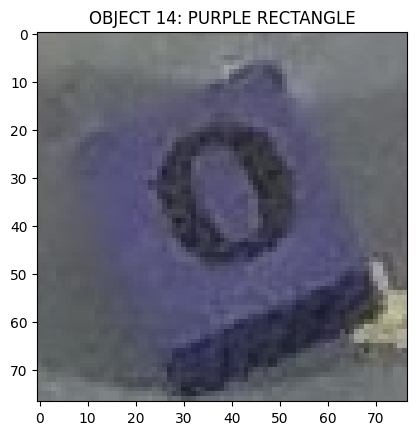

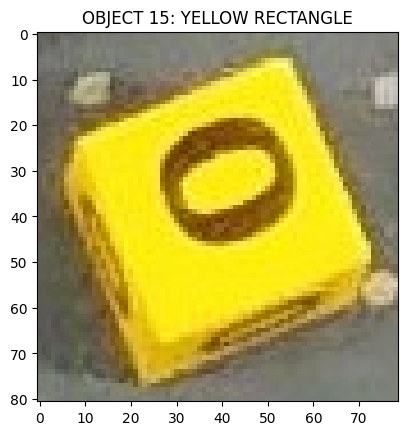

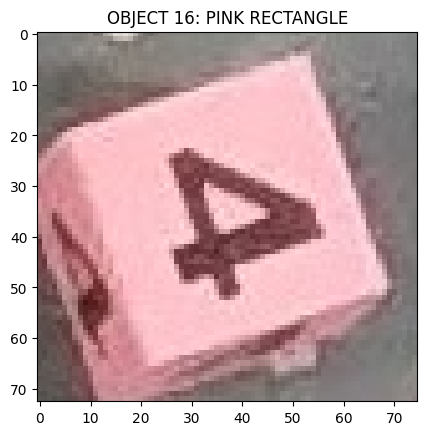

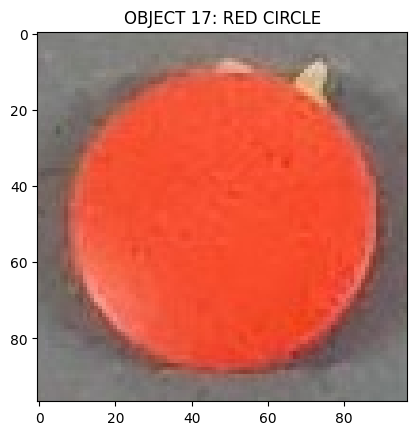

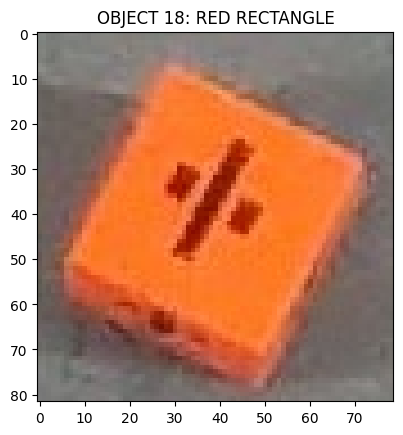

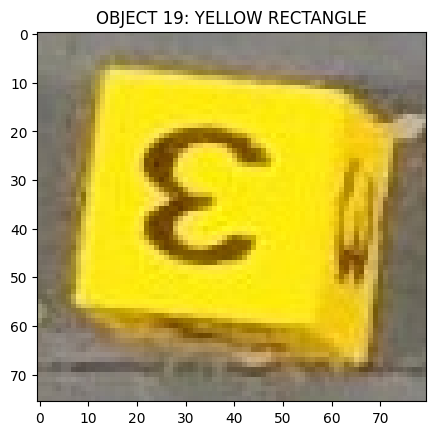

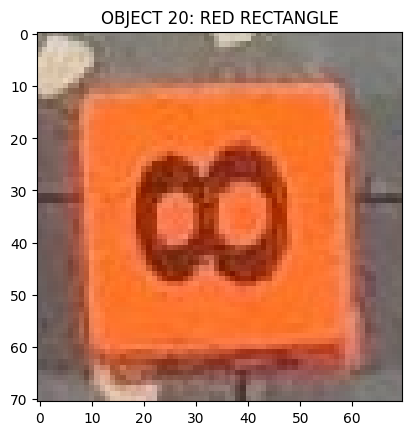

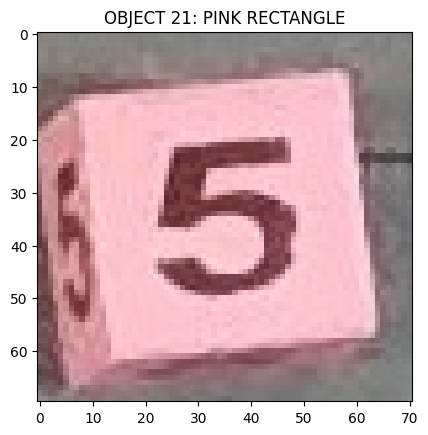

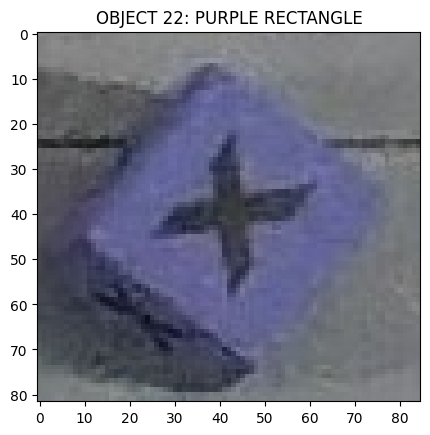

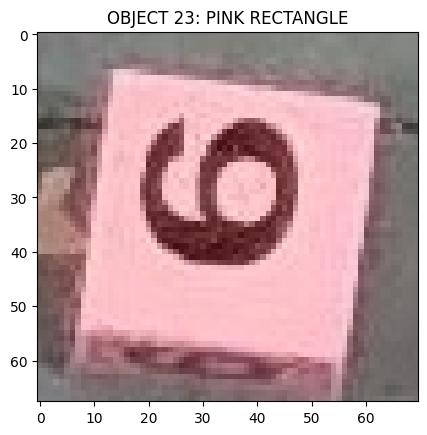

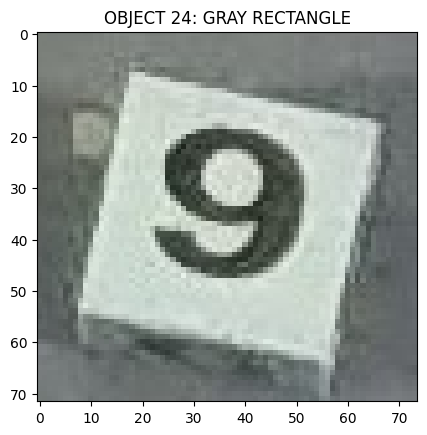

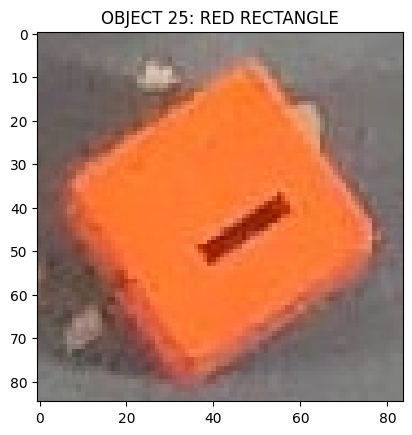

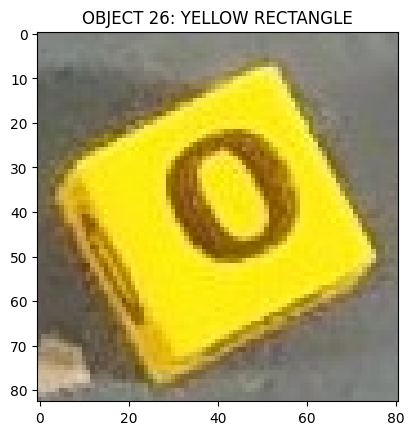

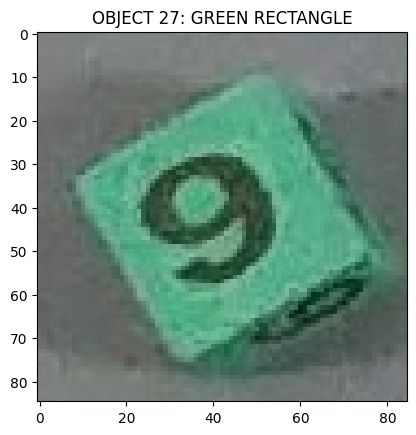

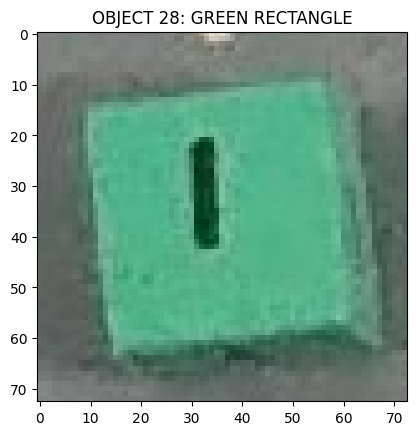

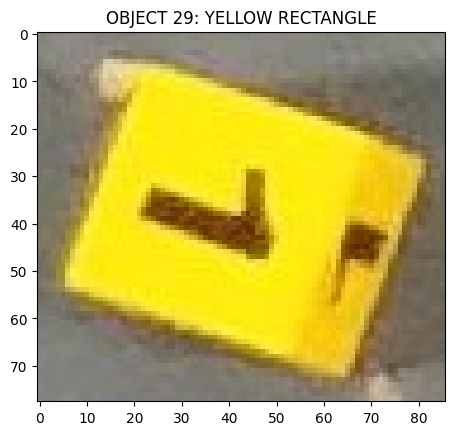

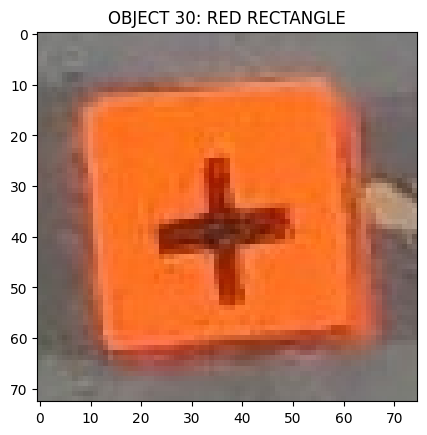

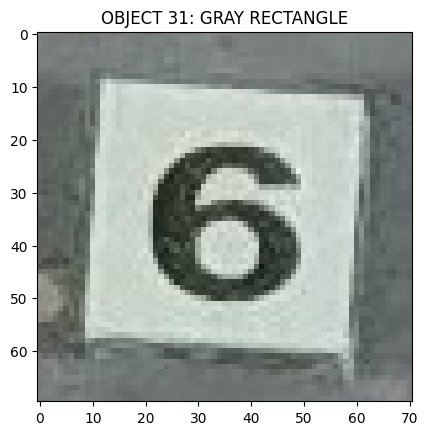

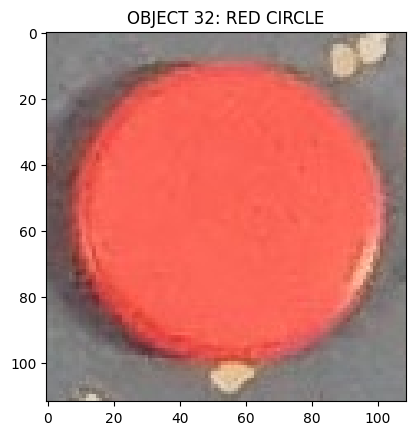

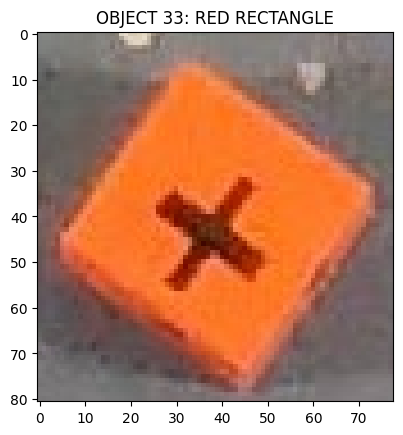

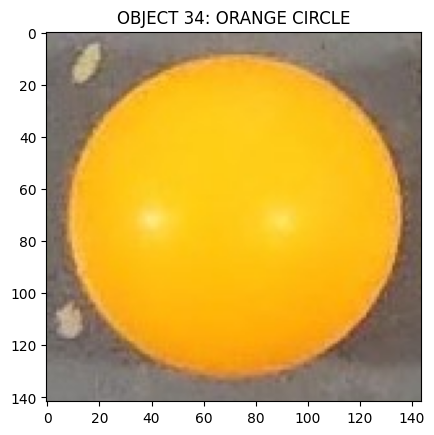

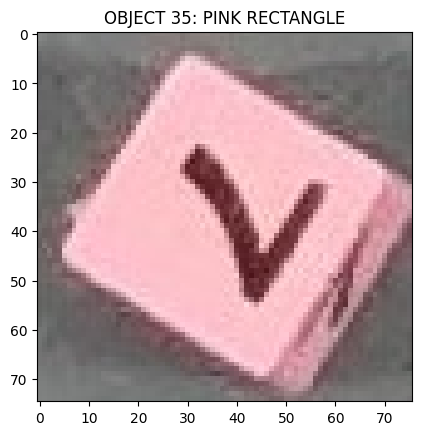

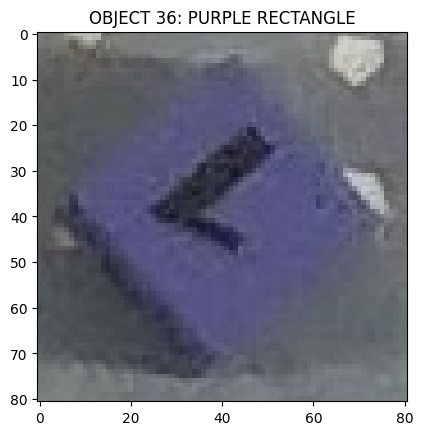

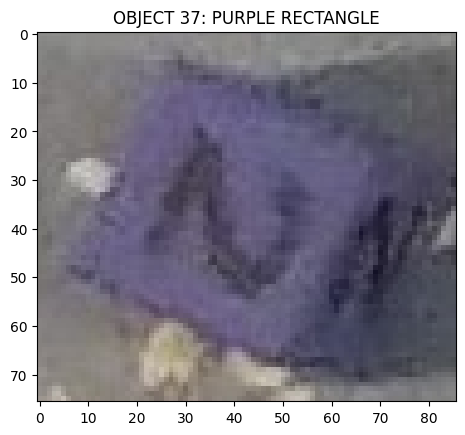

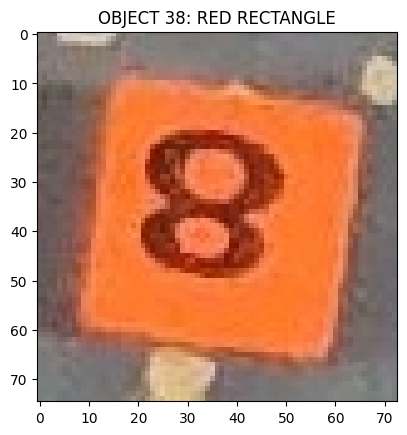

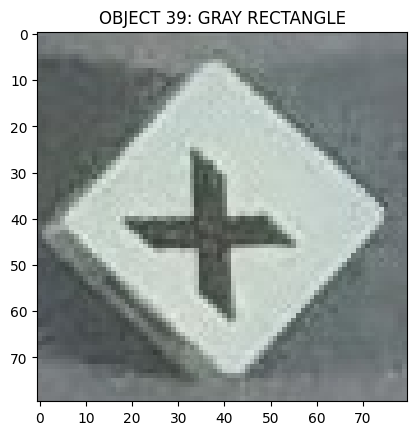

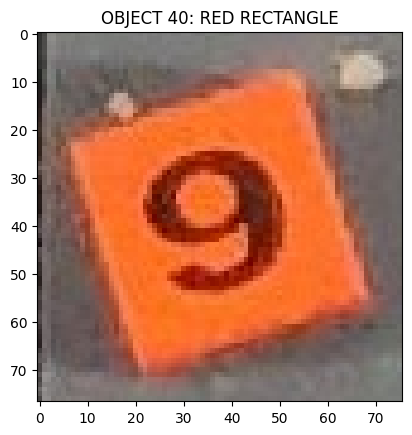

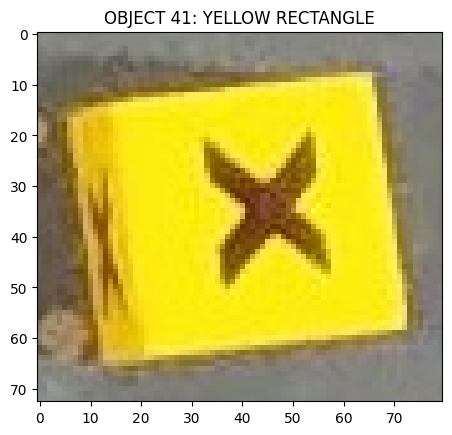

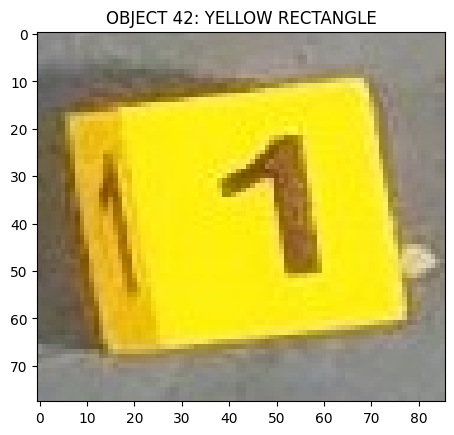

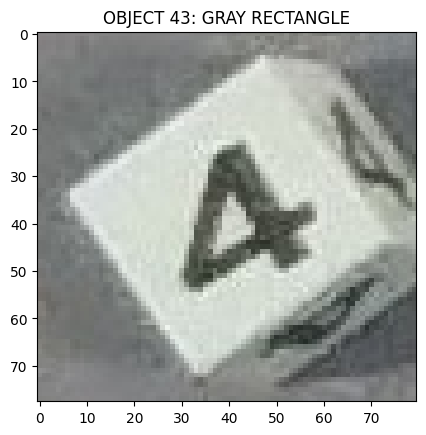

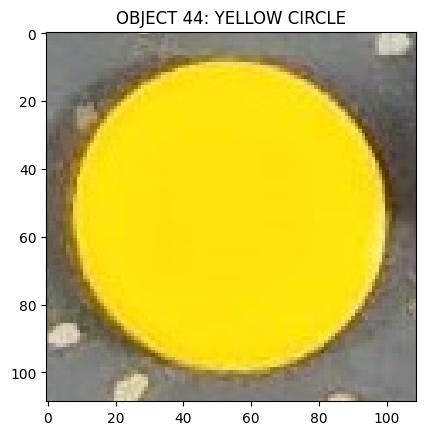

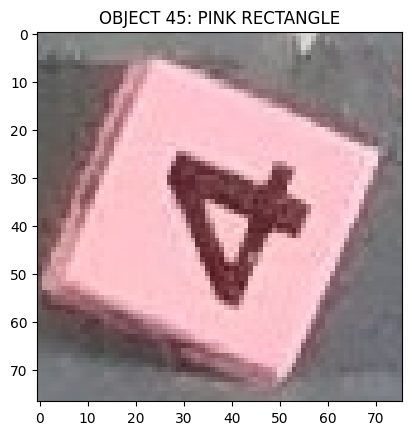

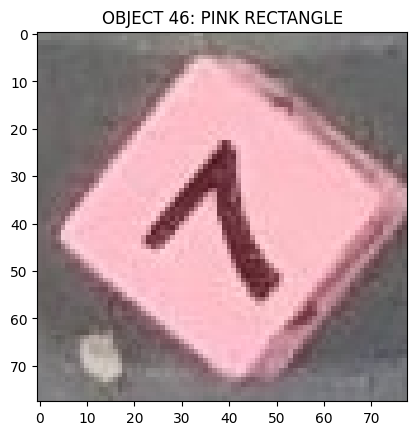

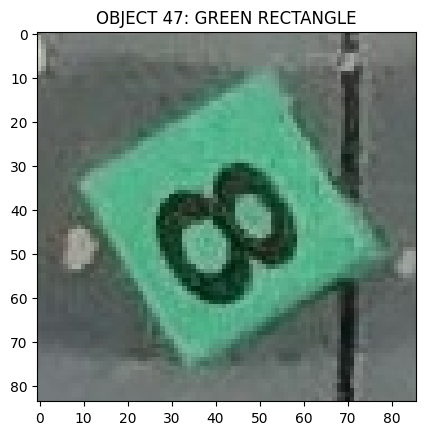

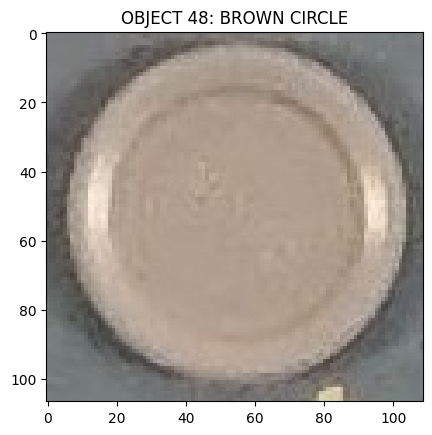

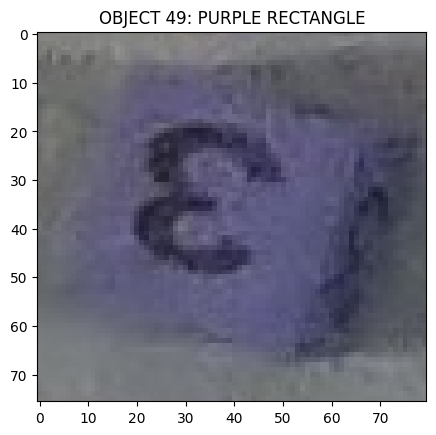

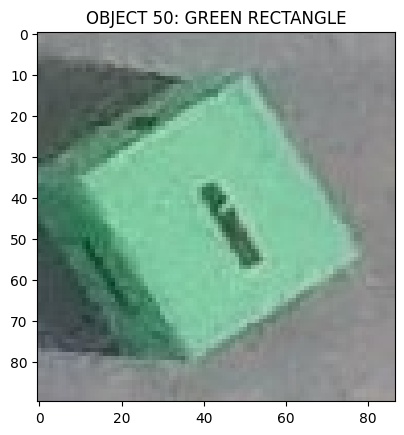

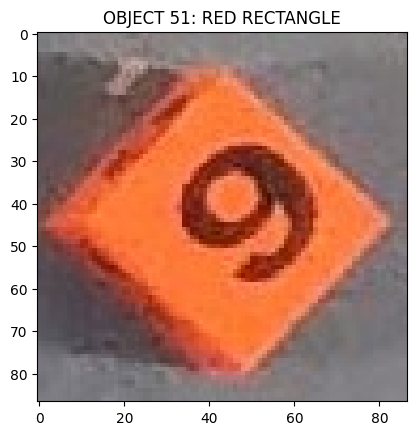

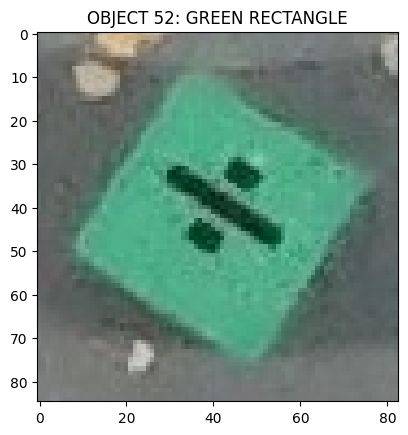

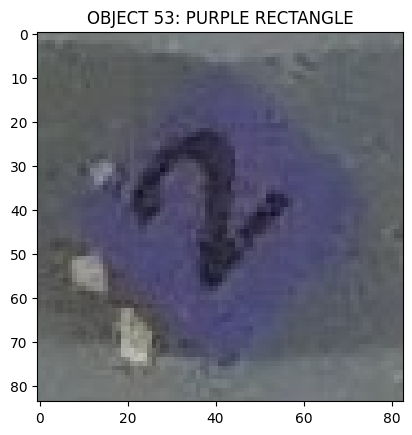

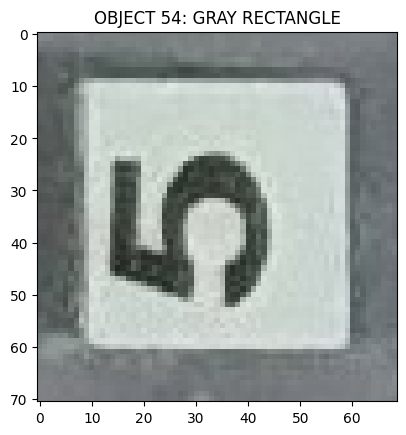

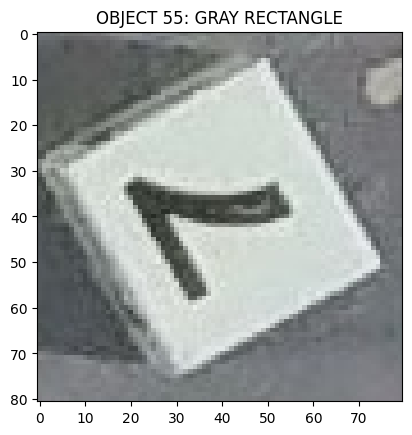

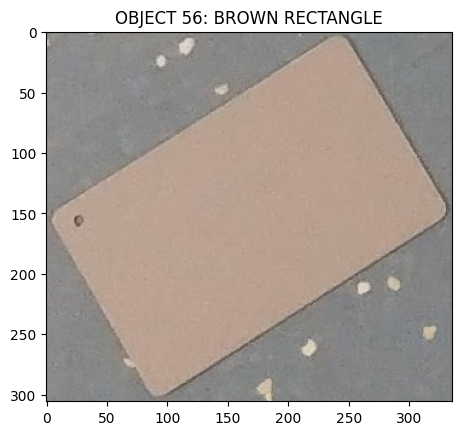

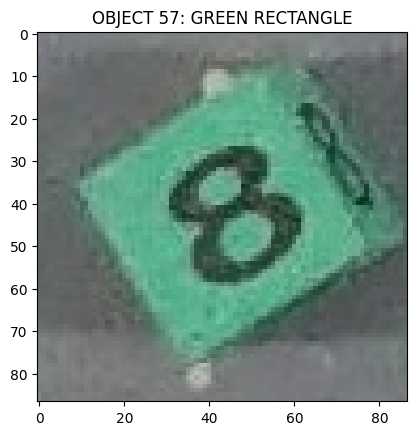

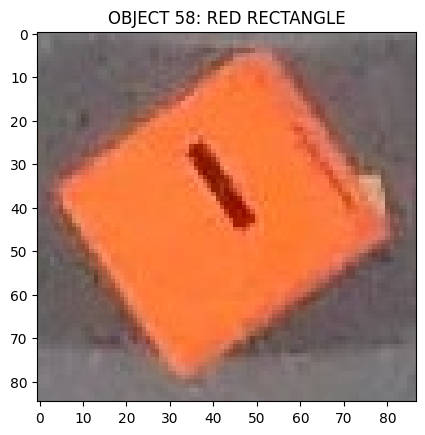

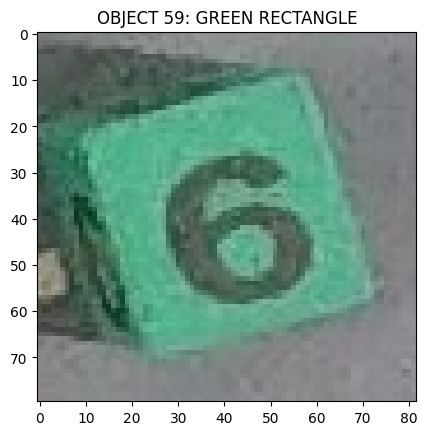

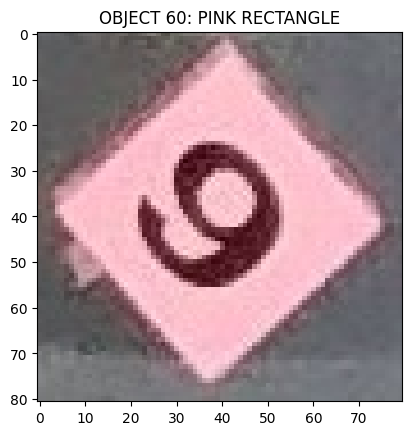

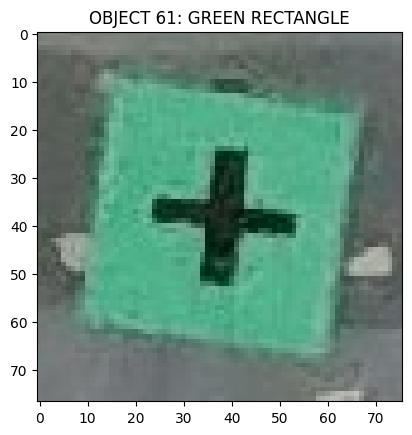

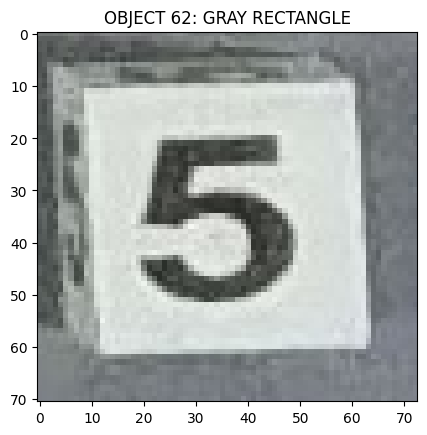

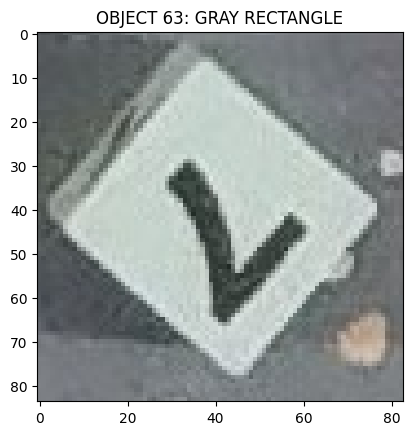

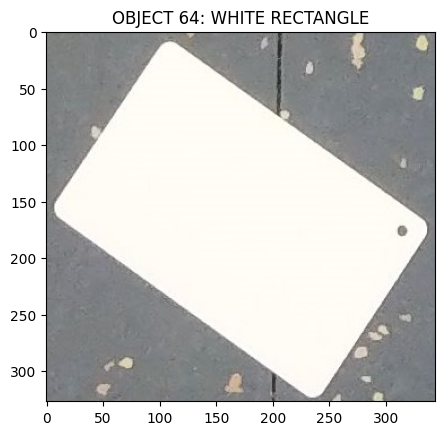

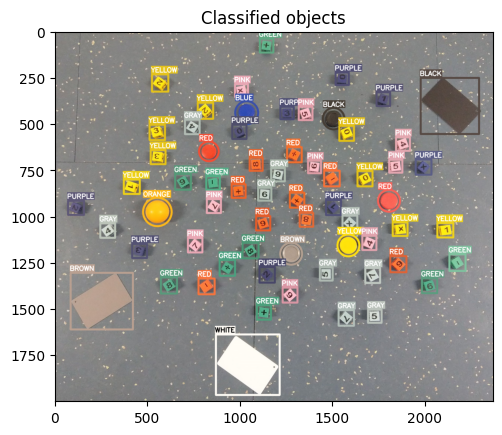

In [32]:
CLASSIFIED_IMG = classify_objects(RGB, HSV, BW_MASK)
show_img(CLASSIFIED_IMG, 'Classified objects', 'rgb')

In [33]:
save_IMG(CLASSIFIED_IMG, 'CLASSIFIED_IMG.jpg')

[INFO]:  Image saved successfully.
